## <center>Bangla Handwritten Math Solver<center> 

In [1]:
# calculate total execution time

from datetime import datetime
start_time = datetime.now()

print('Start Time: {}'.format(start_time))

Start Time: 2023-01-05 11:54:24.196044


## Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import imutils
from imutils.contours import sort_contours
from keras.models import load_model
from rembg import remove
from PIL import Image

2023-01-05 11:54:24.393989: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 11:54:24.524472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/sabikrahat/Documents/Drive-1/AAA-Files/EWU/CSE400C/Final-Draft/bangla_handwritten_math_solver/myenv/lib/python3.8/site-packages/cv2/../../lib64:
2023-01-05 11:54:24.524494: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-05 11:54:25.354638: W tensorflow/compiler/xla/stream_executor/platf

## Loading the Dataset 

In [3]:
x = []
y = []
datadir = 'dataset'
for folder in os.listdir(datadir):
    print(folder + '....')
    path = os.path.join(datadir, folder)
    for images in os.listdir(path):
        img = cv2.imread(os.path.join(path, images))
        x.append(img)
        y.append(folder)
        
print(len(x))
print(len(y))
print(f'labels : {list(set(y))}')

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

div....
0....
1....
2....
3....
4....
5....
6....
7....
8....
9....
add....
mul....
sub....
9068
9068
labels : ['mul', 'div', '0', '3', '4', '8', '1', '2', '5', '6', 'sub', 'add', '7', '9']


### Time Update ###
End Time: 2023-01-05 11:54:56.777230
Duration: 0:00:32.581186


## Visualizing Images in the Dataset 

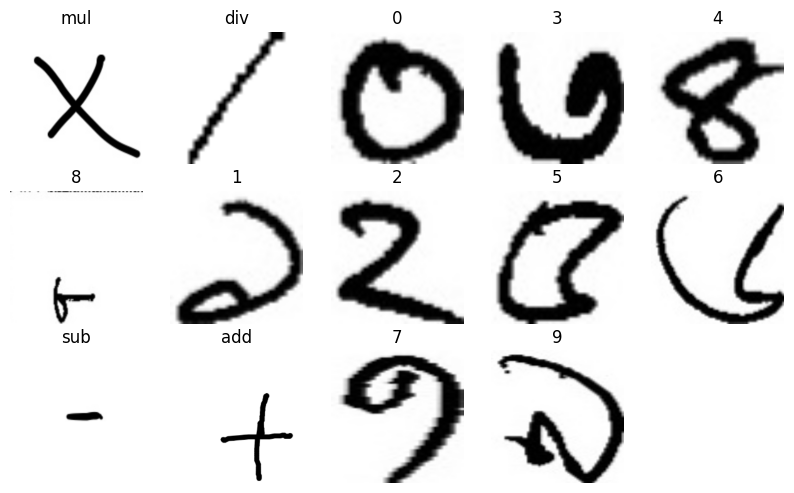

In [4]:
figure = plt.figure(figsize=(10, 10))
j = 0
for i in list(set(y)):
    idx = y.index(i)
    img = x[idx]
    img = cv2.resize(img, (256, 256))
    figure.add_subplot(5, 5, j+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
    j += 1

## Data Distribution of the Dataset 

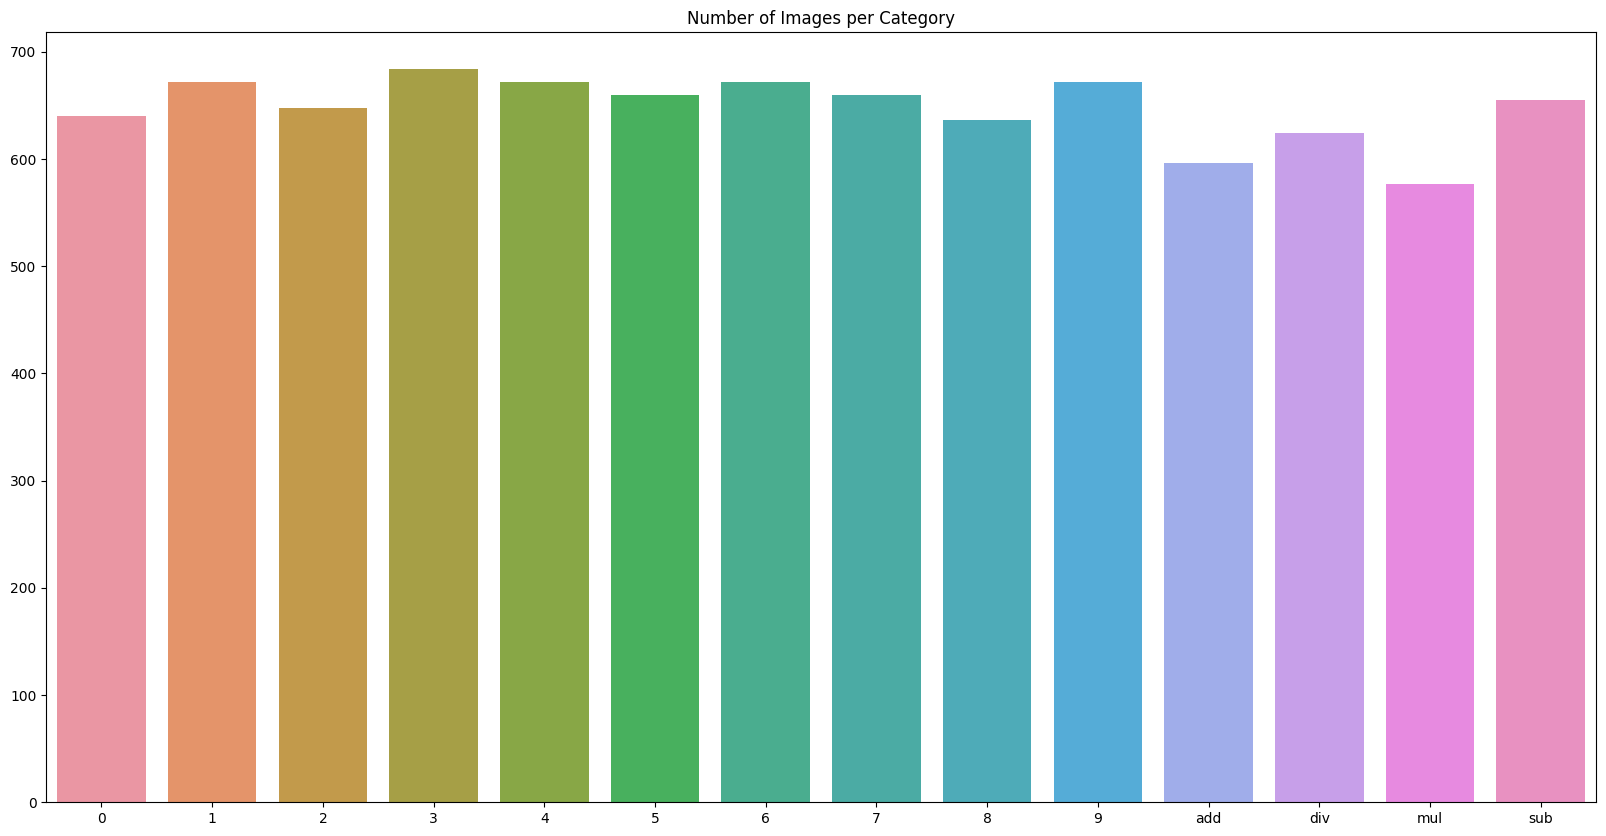

In [5]:
unique, count = np.unique(y, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique, y=count).set_title('Number of Images per Category')
plt.show()

In [6]:
# the dataset is not much imbalanced. So balancing is not required here much.

## Preprocessing the Data

In [7]:
X = []
for i in range(len(x)):
    img = x[i]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    threshold_image = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)[1]
    threshold_image = cv2.resize(threshold_image, (32, 32))
    X.append(threshold_image)
print(len(X))

9068


In [8]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(y)
print(len(y))

9068


In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))

print(len(Y_train))
print(len(Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

7254
1814
7254
1814


### Time Update ###
End Time: 2023-01-05 11:54:58.349199
Duration: 0:00:34.153155


## Data Distribution in Train

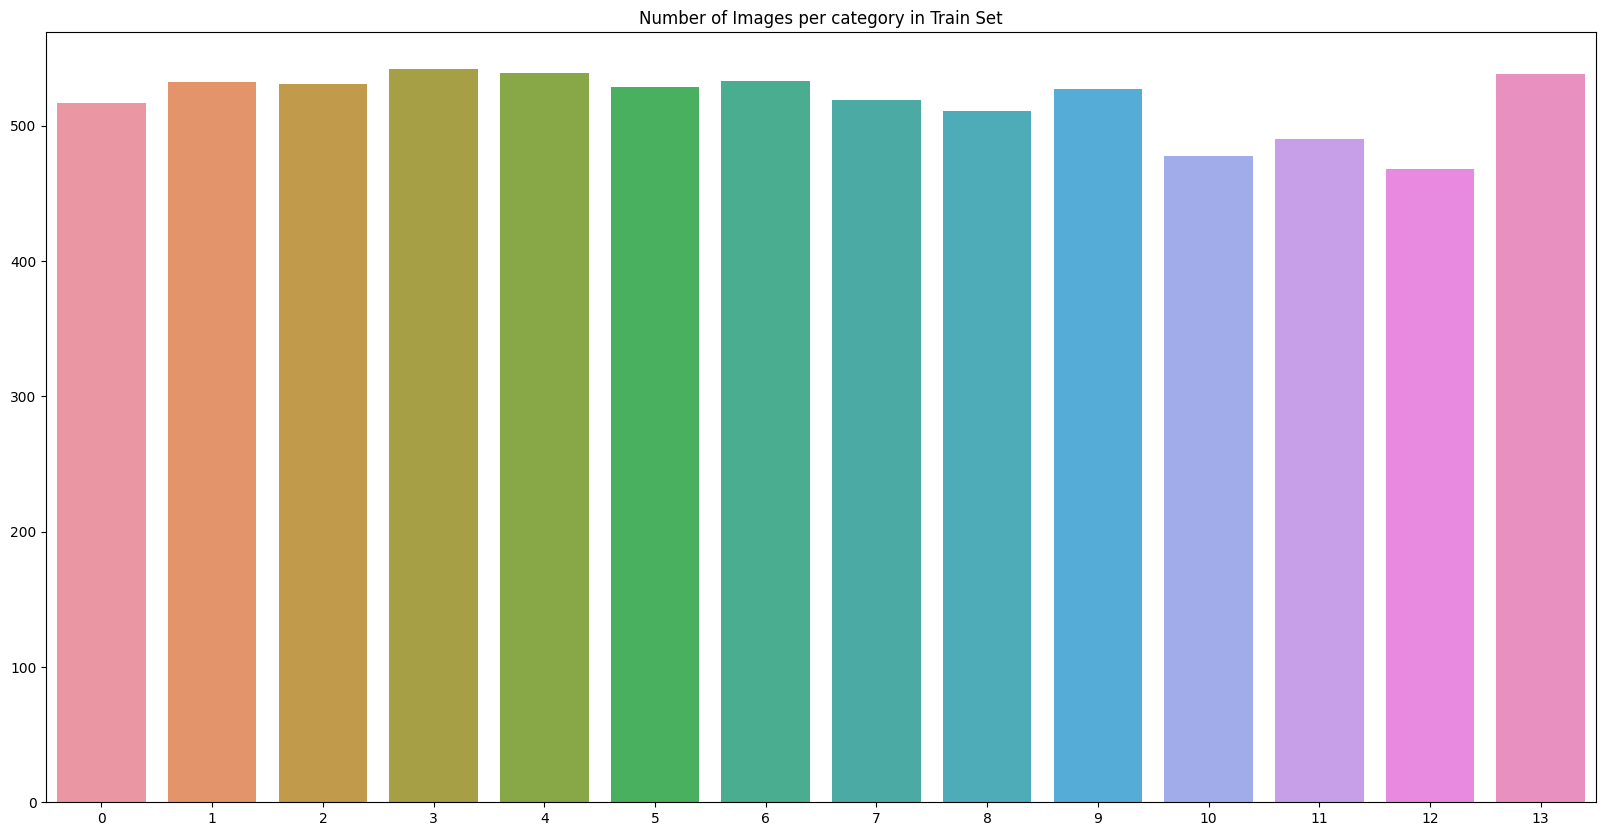

In [10]:
unique_train, count_train = np.unique(Y_train, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_train, y=count_train).set_title('Number of Images per category in Train Set')
plt.show()

## Data Distribution in Test Set

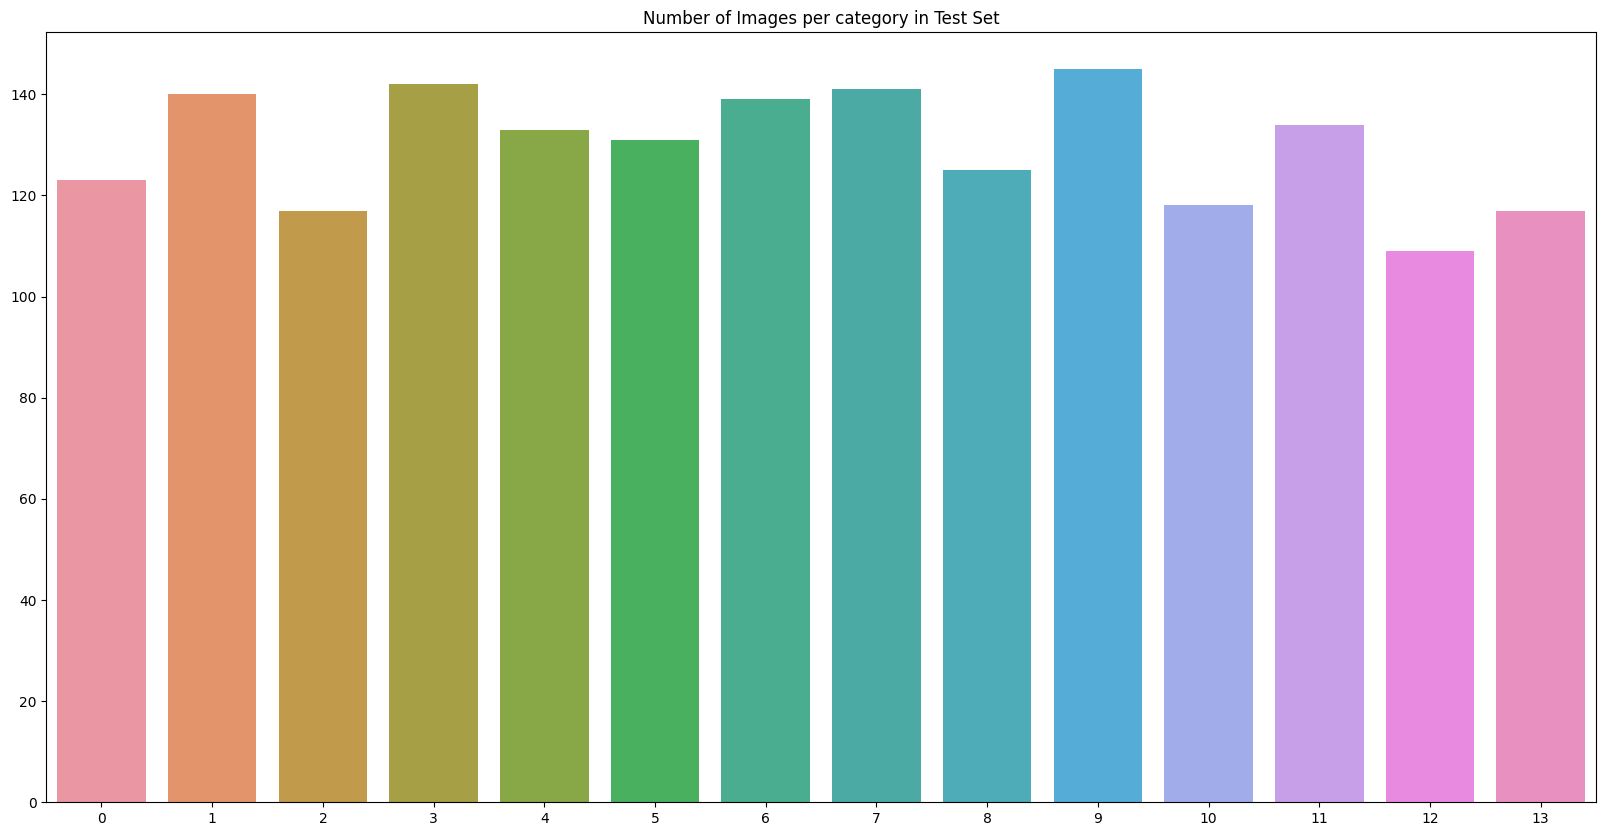

In [11]:
unique_test, count_test = np.unique(Y_test, return_counts=True)
figure = plt.figure(figsize=(20, 10))
sb.barplot(x=unique_test, y=count_test).set_title('Number of Images per category in Test Set')
plt.show()

## Defining the Model 

In [12]:
X_train = np.array(X_train)
X_test = np.array(X_test)
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train/255.
X_test = X_test/255.

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(7254, 32, 32, 1)
(1814, 32, 32, 1)
(7254, 14)
(1814, 14)


In [13]:
def math_symbol_and_digits_recognition(input_shape=(32, 32, 1)):
    regularizer = l2(0.01)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv1', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act1'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(32, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv2', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act2'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', 
                     kernel_initializer=glorot_uniform(seed=0), 
                     name='conv3', activity_regularizer=regularizer))
    model.add(Activation(activation='relu', name='act3'))
    model.add(MaxPool2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(120, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc1'))
    model.add(Dense(84, activation='relu', kernel_initializer=glorot_uniform(seed=0), name='fc2'))
    model.add(Dense(14, activation='softmax', kernel_initializer=glorot_uniform(seed=0), name='fc3'))
    
    optimizer = Adam()
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [14]:
model = math_symbol_and_digits_recognition(input_shape=(32, 32, 1))
model.summary()

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 32, 32, 32)        320       
                                                                 
 act1 (Activation)           (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 16, 16, 32)        9248      
                                                                 
 act2 (Activation)           (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

2023-01-05 11:55:10.256011: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-05 11:55:10.256053: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sabikrahat-hp-fedora): /proc/driver/nvidia/version does not exist
2023-01-05 11:55:10.256762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##  Training the Model

In [15]:
def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

checkpoint = ModelCheckpoint('math_symbol_and_digits_recognition.h5', 
                             monitor='val_loss', save_best_only=True, 
                             verbose=1, mode='min')

callbacks = [checkpoint, LearningRateScheduler(step_decay)]


########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2023-01-05 11:55:10.484277
Duration: 0:00:46.288233


In [16]:
aug = ImageDataGenerator(zoom_range=0.1,
                         width_shift_range=0.05,
                         height_shift_range=0.05)
hist = model.fit(aug.flow(X_train, Y_train, batch_size=128), batch_size=128, epochs=100, validation_data=(X_test, Y_test))

        
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))

Epoch 1/100
57/57 [==============================] - 7s 104ms/step - loss: 3.0163 - accuracy: 0.3816 - val_loss: 1.6979 - val_accuracy: 0.7514
Epoch 2/100
57/57 [==============================] - 6s 102ms/step - loss: 1.1699 - accuracy: 0.7830 - val_loss: 1.0003 - val_accuracy: 0.8512
Epoch 3/100
57/57 [==============================] - 6s 104ms/step - loss: 0.7951 - accuracy: 0.8464 - val_loss: 0.7895 - val_accuracy: 0.8699
Epoch 4/100
57/57 [==============================] - 6s 98ms/step - loss: 0.6621 - accuracy: 0.8661 - val_loss: 0.8044 - val_accuracy: 0.8660
Epoch 5/100
57/57 [==============================] - 6s 100ms/step - loss: 0.5736 - accuracy: 0.8785 - val_loss: 0.5755 - val_accuracy: 0.9035
Epoch 6/100
57/57 [==============================] - 6s 100ms/step - loss: 0.5226 - accuracy: 0.8865 - val_loss: 0.5779 - val_accuracy: 0.9024
Epoch 7/100
57/57 [==============================] - 6s 107ms/step - loss: 0.4675 - accuracy: 0.8985 - val_loss: 0.5066 - val_accuracy: 0.9079


57/57 [==============================] - 6s 100ms/step - loss: 0.1242 - accuracy: 0.9734 - val_loss: 0.1793 - val_accuracy: 0.9686
Epoch 59/100
57/57 [==============================] - 6s 105ms/step - loss: 0.1232 - accuracy: 0.9734 - val_loss: 0.2147 - val_accuracy: 0.9642
Epoch 60/100
57/57 [==============================] - 6s 109ms/step - loss: 0.1208 - accuracy: 0.9749 - val_loss: 0.1610 - val_accuracy: 0.9752
Epoch 61/100
57/57 [==============================] - 7s 116ms/step - loss: 0.1315 - accuracy: 0.9715 - val_loss: 0.2067 - val_accuracy: 0.9603
Epoch 62/100
57/57 [==============================] - 6s 111ms/step - loss: 0.1356 - accuracy: 0.9697 - val_loss: 0.2040 - val_accuracy: 0.9587
Epoch 63/100
57/57 [==============================] - 6s 101ms/step - loss: 0.1161 - accuracy: 0.9756 - val_loss: 0.1642 - val_accuracy: 0.9713
Epoch 64/100
57/57 [==============================] - 6s 102ms/step - loss: 0.1194 - accuracy: 0.9746 - val_loss: 0.1775 - val_accuracy: 0.9669
Epoch

##  Loss and Accuracy Plot

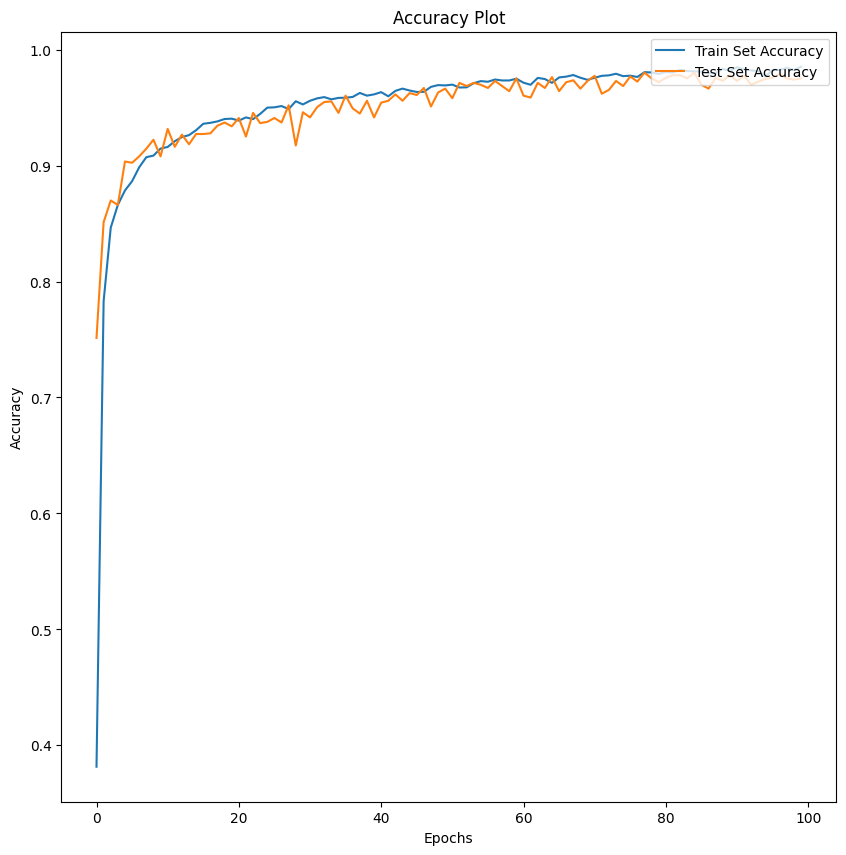

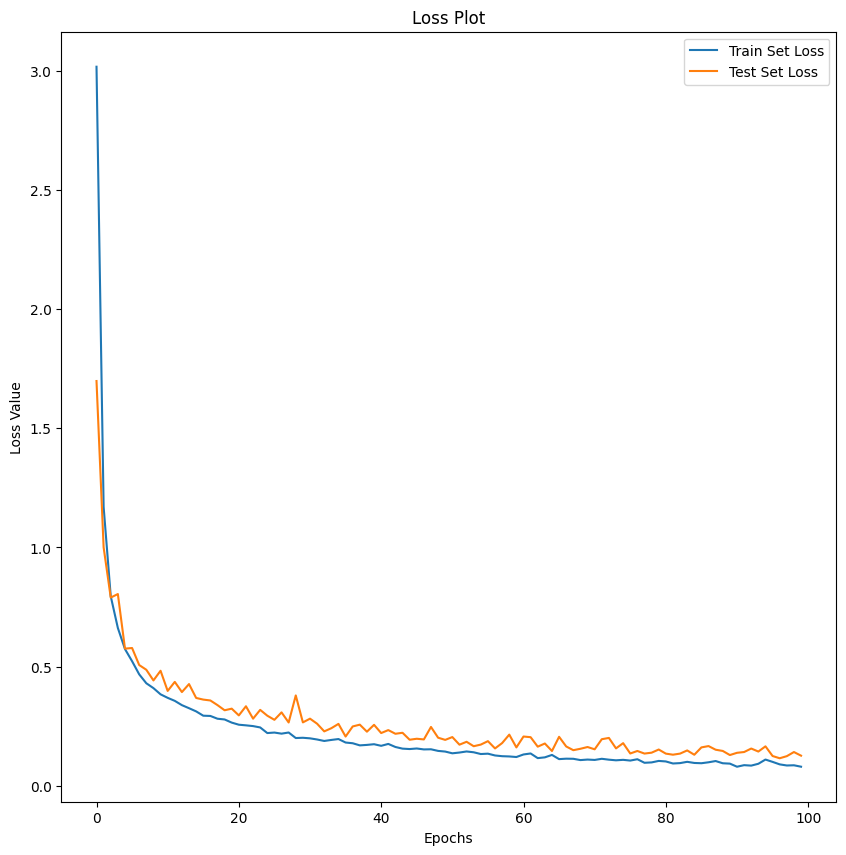

In [17]:
figure = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train Set Accuracy')
plt.plot(hist.history['val_accuracy'], label='Test Set Accuracy')
plt.title('Accuracy Plot')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train Set Loss')
plt.plot(hist.history['val_loss'], label='Test Set Loss')
plt.title('Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend(loc='upper right')
plt.show()

## Confusion Matrix 

57/57 [==============================] - 1s 7ms/step


<AxesSubplot: >

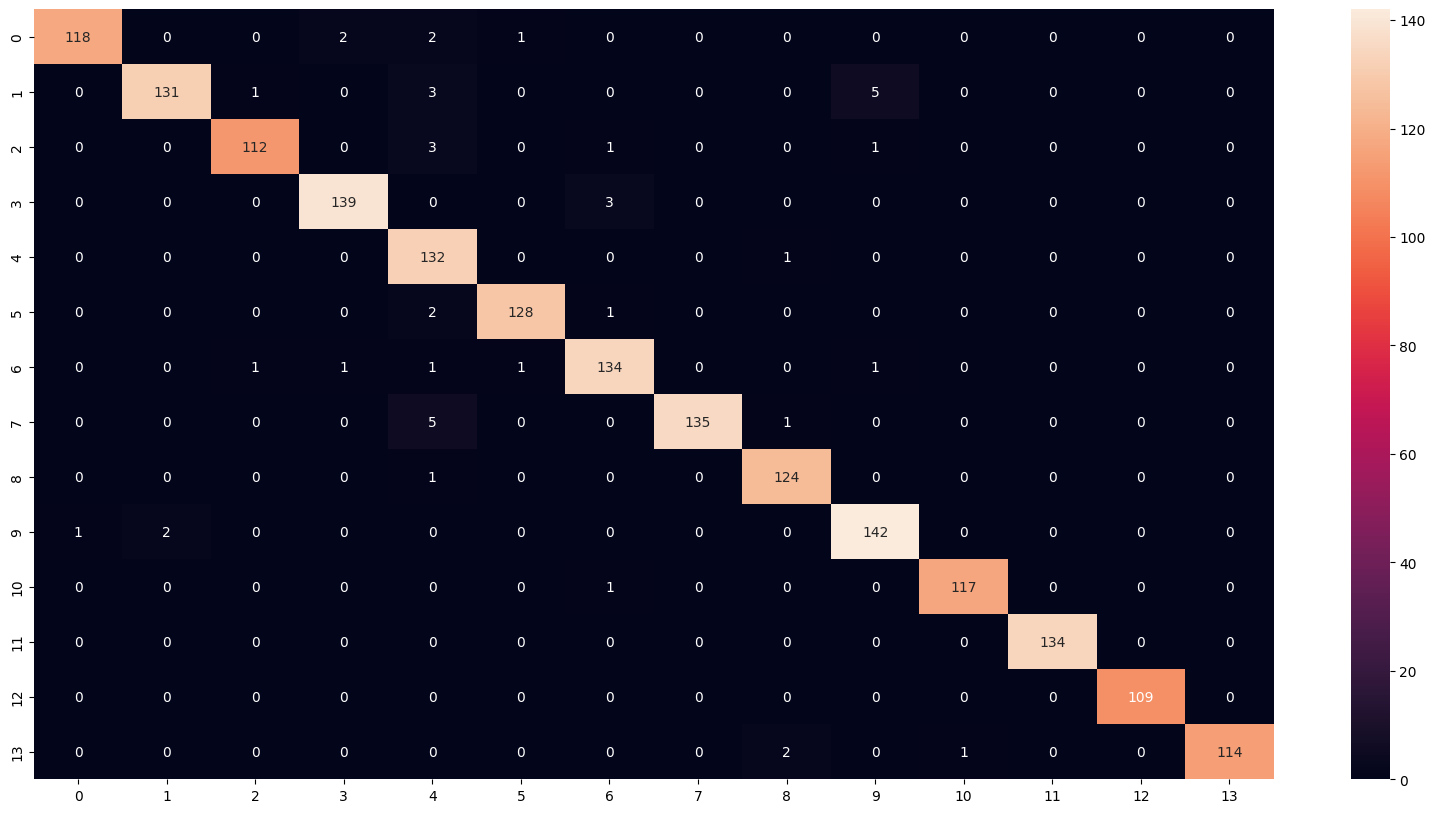

In [18]:
ypred = model.predict(X_test)
ypred = np.argmax(ypred, axis=1)
Y_test_hat = np.argmax(Y_test, axis=1)

matrix = confusion_matrix(Y_test_hat, ypred)
df_cm = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], 
                     columns=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
figure = plt.figure(figsize=(20, 10))
sb.heatmap(df_cm, annot=True, fmt='d')

## Classification Report

In [19]:
print(classification_report(Y_test_hat, ypred))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       123
           1       0.98      0.94      0.96       140
           2       0.98      0.96      0.97       117
           3       0.98      0.98      0.98       142
           4       0.89      0.99      0.94       133
           5       0.98      0.98      0.98       131
           6       0.96      0.96      0.96       139
           7       1.00      0.96      0.98       141
           8       0.97      0.99      0.98       125
           9       0.95      0.98      0.97       145
          10       0.99      0.99      0.99       118
          11       1.00      1.00      1.00       134
          12       1.00      1.00      1.00       109
          13       1.00      0.97      0.99       117

    accuracy                           0.98      1814
   macro avg       0.98      0.98      0.98      1814
weighted avg       0.98      0.98      0.98      1814



## Saving the Model 

In [20]:
model.save('math_symbol_and_digit_recognition.h5')

## Total Execution Time

In [21]:
########## Time Calculation #################
print("\n\n### Time Update ###")
end_time = datetime.now()
print('End Time: {}'.format(end_time))
print('Duration: {}'.format(end_time - start_time))



### Time Update ###
End Time: 2023-01-05 12:05:59.110273
Duration: 0:11:34.914229
